<a href="https://www.kaggle.com/code/abhijitdarekar001/featrureeng-xgboost-hyperparamoptimization?scriptVersionId=152902148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Understanding Features

Features:
<ul>
<li><b>allelectrons_Total:</b> The total number of electrons in the material.
    </li><li><b>density_Total:</b> The total density of the material, often measured in mass per unit volume.
</li><li><b>allelectrons_Average:</b> The average number of electrons per atom in the material.
</li><li><b>val_e_Average:</b> The average number of valence electrons per atom in the material.
</li><li><b>atomicweight_Average:</b> The average atomic weight of the atoms in the material.
</li><li><b>ionenergy_Average:</b> The average ionization energy, which is the energy required to remove an electron from an atom or a positive ion.
</li><li><b>el_neg_chi_Average:</b> The average electronegativity according to the Pauling scale, which measures the tendency of an atom to attract a bonding pair of electrons.
</li><li><b>R_vdw_element_Average:</b> The average van der Waals radius of the atoms in the material.
</li><li><b>R_cov_element_Average:</b> The average covalent radius of the atoms in the material.
</li><li><b>zaratio_Average:</b> The average ratio of the atomic number to the atomic radius.
</li><li><b>density_Average:</b> The average density of the material.
</li><li><b>Hardness:</b> The Mohs Hardness of the material, which is a measure of its resistance to scratching.
</ul>


For Evaluation we will use MAE(Mean Absolute Error) as MAE as it is less sensiteve to outliers.

### Reading and Cleaning Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

from sklearn.model_selection import GridSearchCV

from hyperopt import hp, STATUS_OK,Trials, tpe, fmin
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")

In [3]:
df.isna().sum()/len(df)*100

id                       0.0
allelectrons_Total       0.0
density_Total            0.0
allelectrons_Average     0.0
val_e_Average            0.0
atomicweight_Average     0.0
ionenergy_Average        0.0
el_neg_chi_Average       0.0
R_vdw_element_Average    0.0
R_cov_element_Average    0.0
zaratio_Average          0.0
density_Average          0.0
Hardness                 0.0
dtype: float64

No empty columns

In [4]:
df.duplicated().sum()

0

No Duplcate Values present in training dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
df.drop('id', axis = 1, inplace=True)
num_cols = [col for col in df.columns if df[col].dtype in ['int64','float64']]
print("Continous features : ",num_cols)

cat_cols = [col for col in df.columns if df[col].dtype not in ['int64','float64']]
print("Catogerical features: ",cat_cols)

Continous features :  ['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average', 'Hardness']
Catogerical features:  []


### Data Exploration

#### Correlation graph

<Axes: >

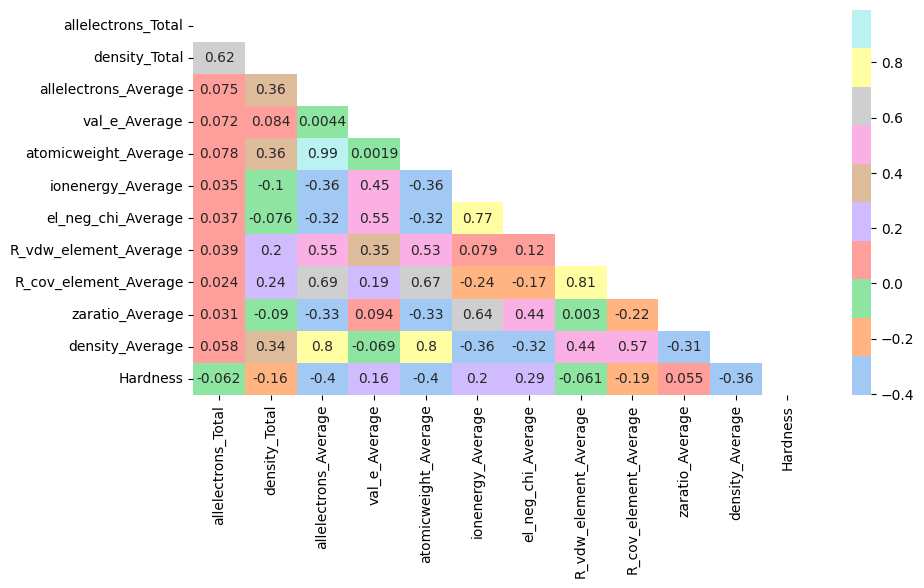

In [7]:
#Correaltion map
corr = df.corr(numeric_only  =True)
plt.figure(figsize= (10,5))
sns.color_palette('pastel')
sns.heatmap(corr,annot = True,cmap=sns.color_palette('pastel'),mask= np.triu(np.ones_like(corr))
)

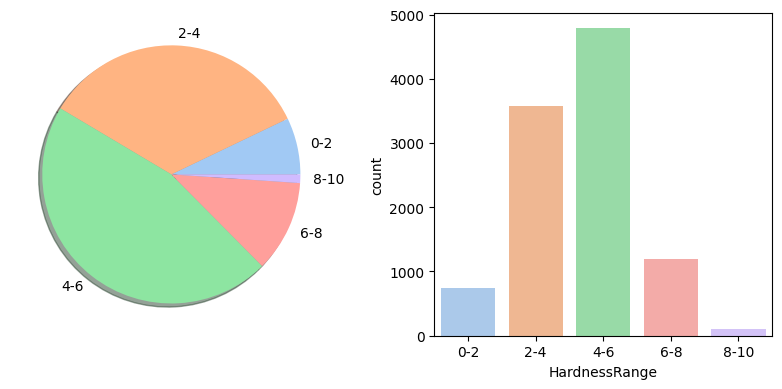

In [8]:
df['HardnessRange'] = pd.cut(df.Hardness,
                            bins=[-np.inf, 2, 4, 6, 8, np.inf],
                            labels=["0-2","2-4",'4-6',"6-8","8-10"])
plt.figure(figsize = (8,4))
plt.title("Range of Hardness")
plt.subplot(1,2,1)
palette_color = sns.color_palette('pastel')
plt.pie(list(df['HardnessRange'].value_counts(sort = False).values),
        labels=list(df['HardnessRange'].value_counts(sort = False).index),colors=palette_color,shadow=0.1)

plt.subplot(1,2,2)
sns.countplot(df, x= 'HardnessRange',palette = palette_color)
plt.tight_layout()

##### Analysing Numerical Columns

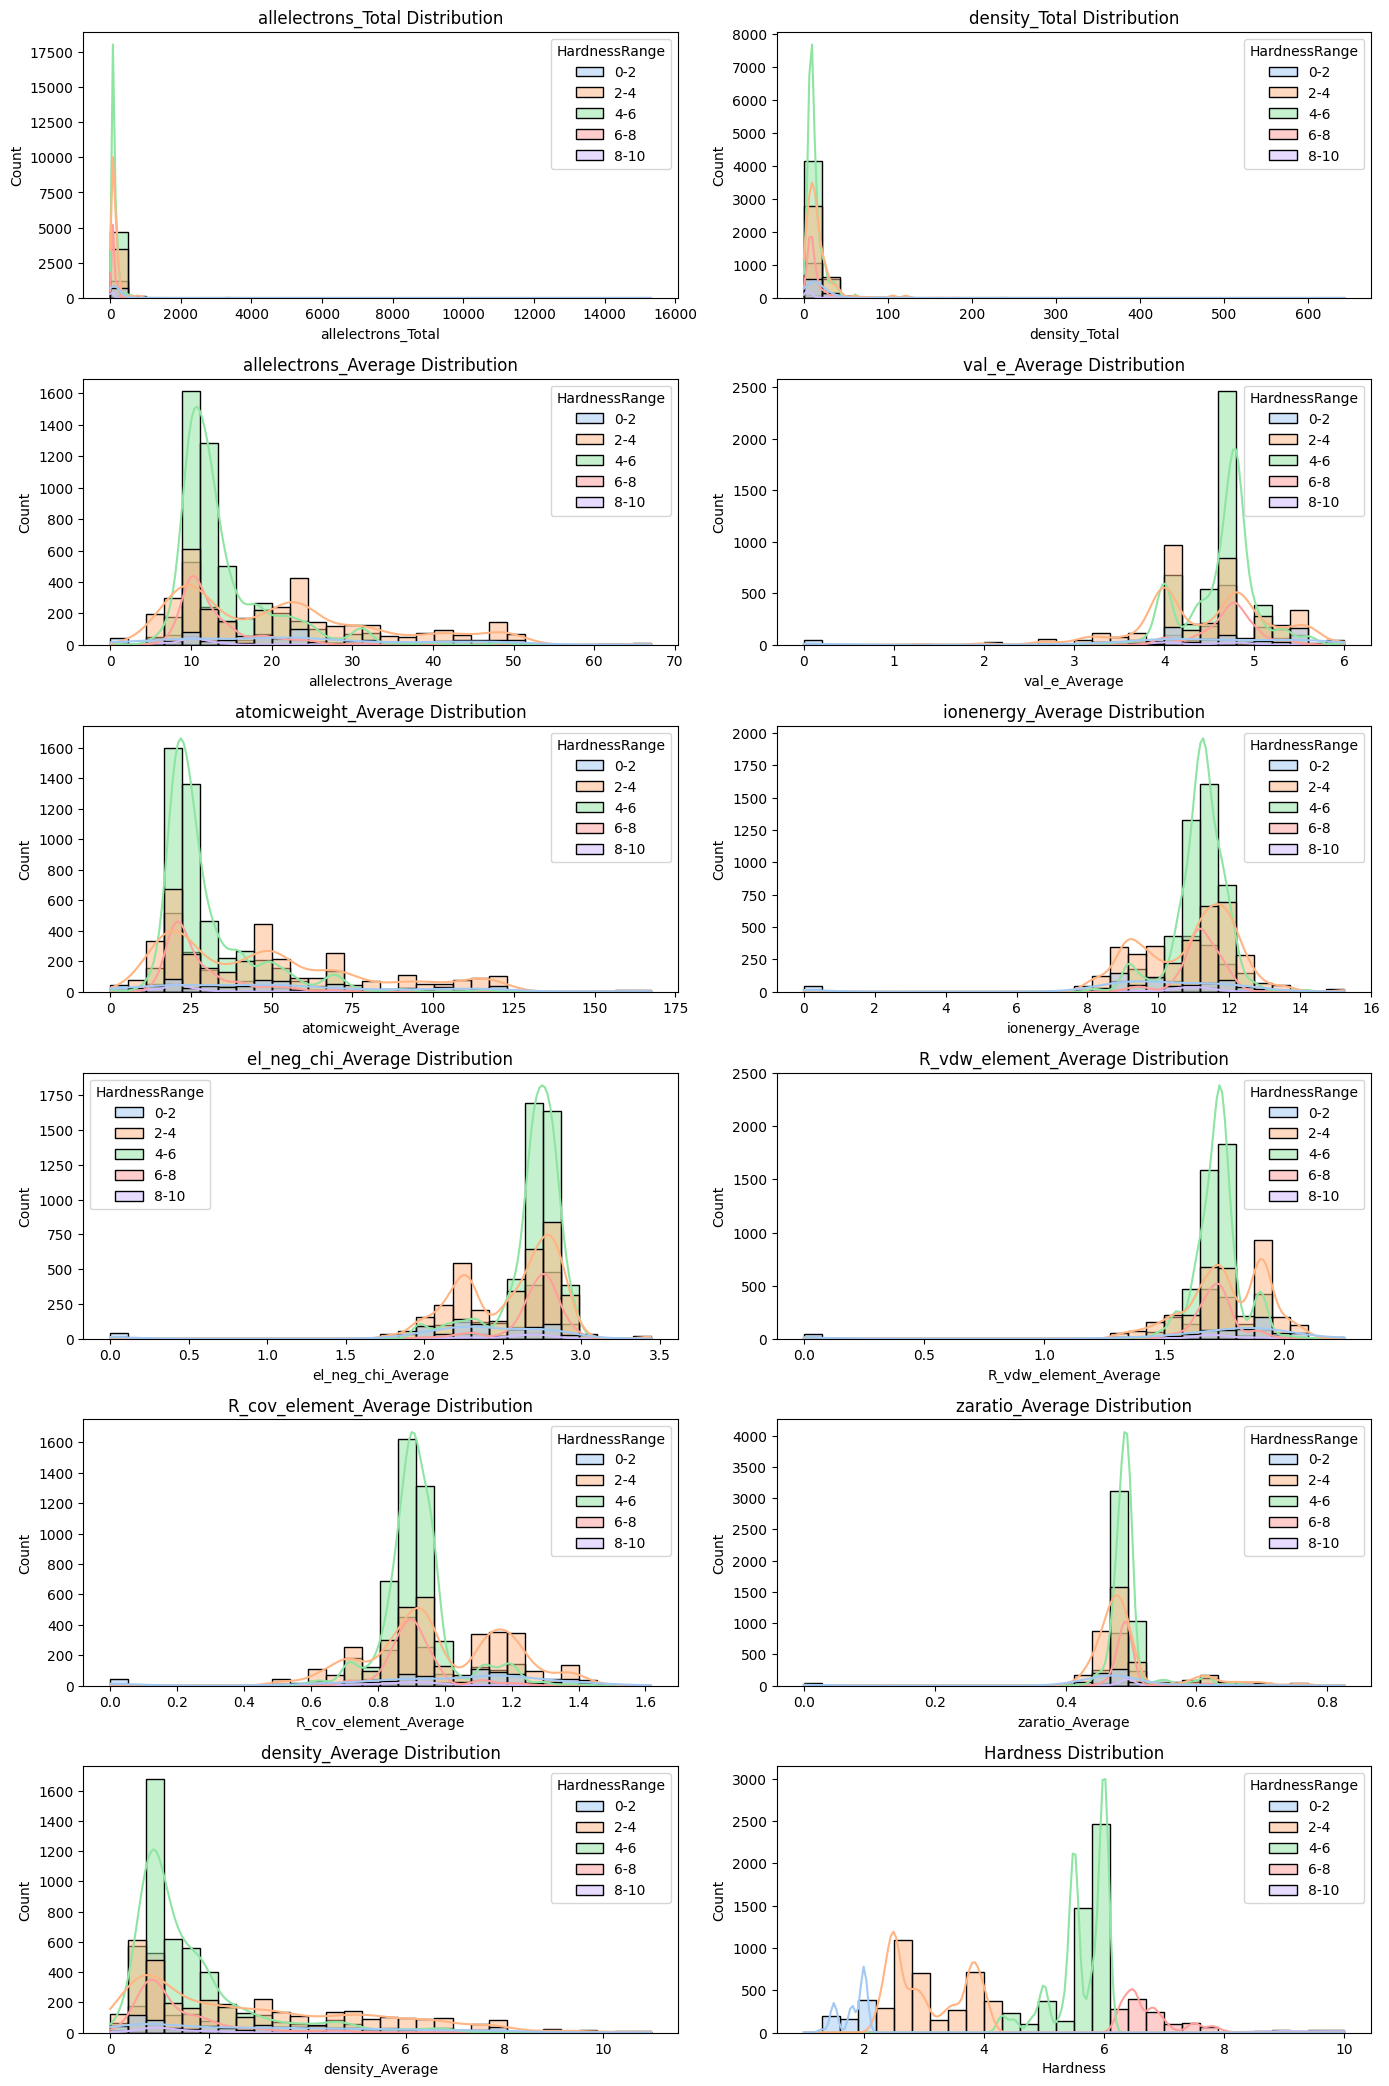

In [9]:
plt.figure(figsize=(14,len(num_cols)*2))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.histplot(x=column, hue="HardnessRange", data=df,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

#### Analysing Target Variable

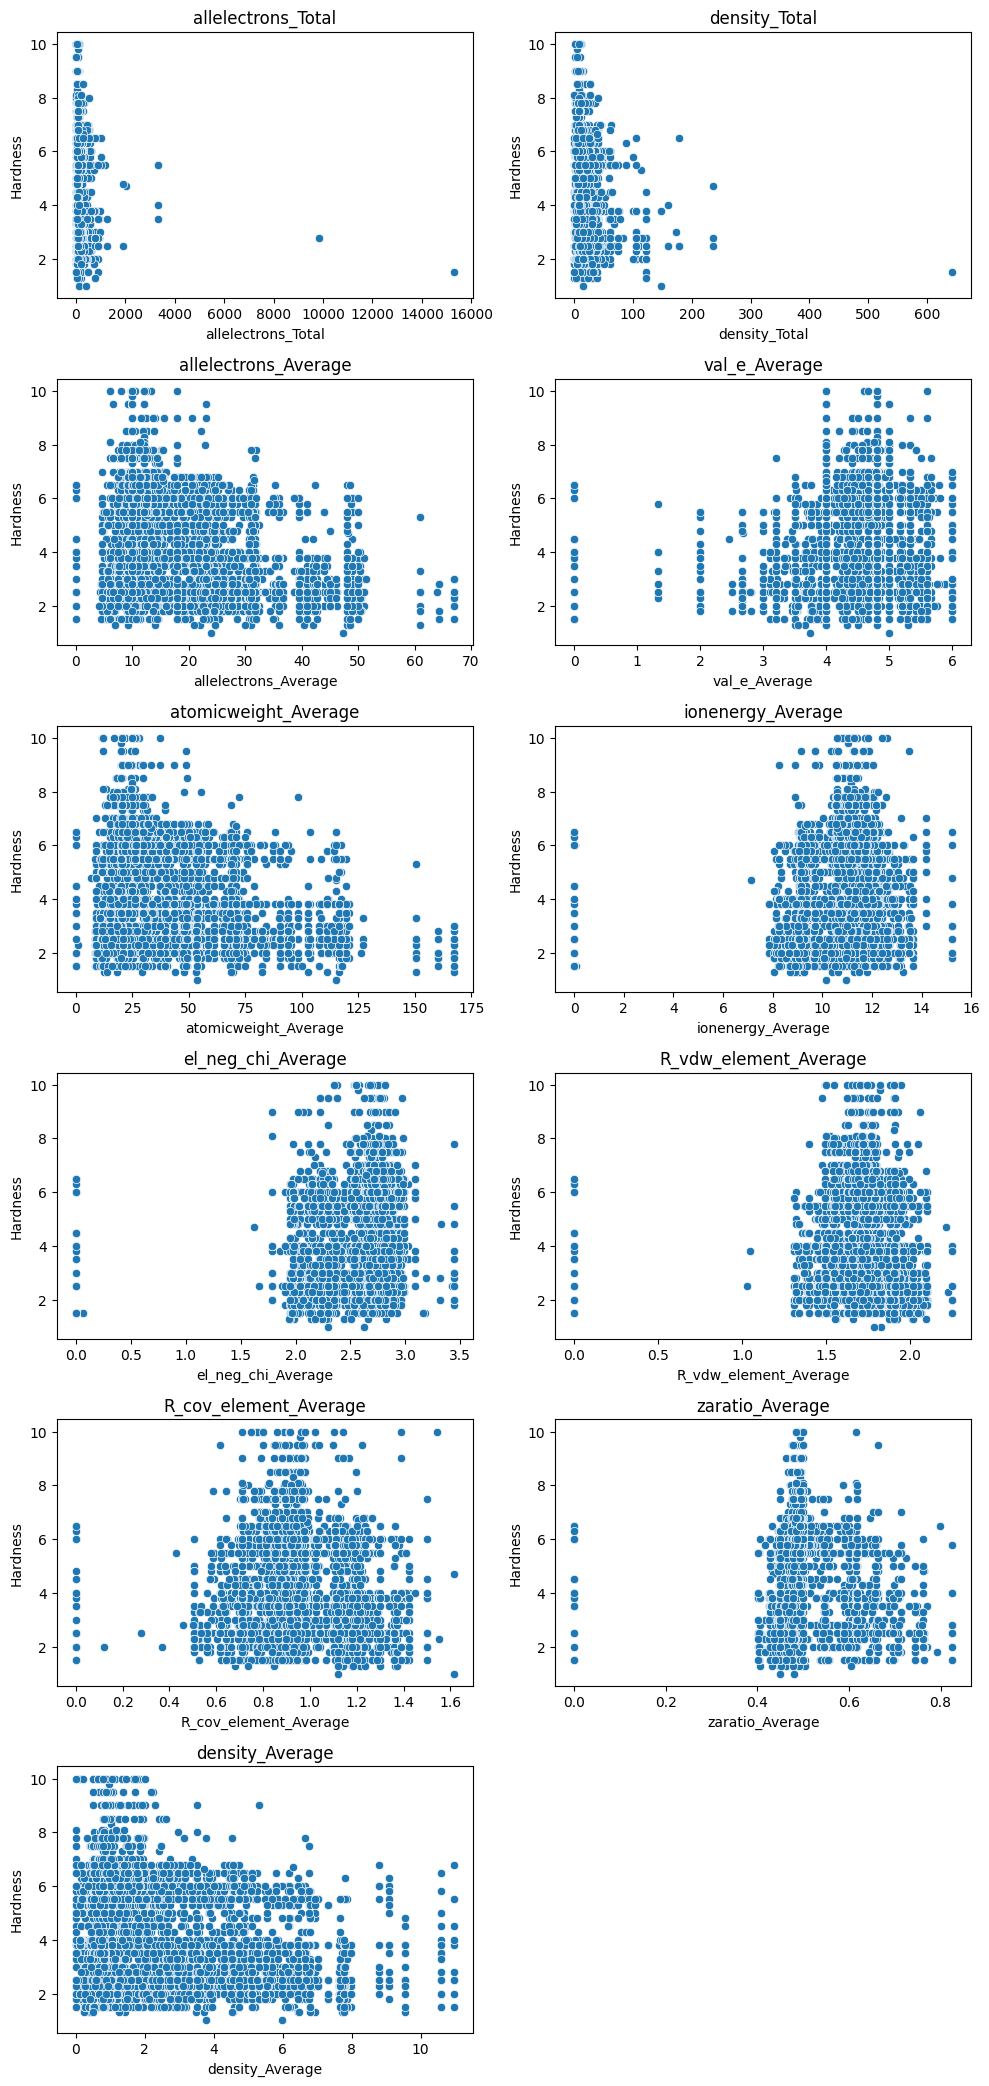

In [10]:
plt.figure(figsize=(10,len(num_cols)*2))
for idx,column in enumerate(num_cols):
    if column != "Hardness":
        plt.subplot(len(num_cols)//2+1,2,idx+1)
        sns.scatterplot(y='Hardness', x = column, data =df,palette = sns.color_palette('flare'))
        plt.title(column)
        plt.tight_layout()

### Feature Engineering

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [12]:
X = df.drop(['Hardness','HardnessRange'],axis =1)
y = df['Hardness']

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.3)

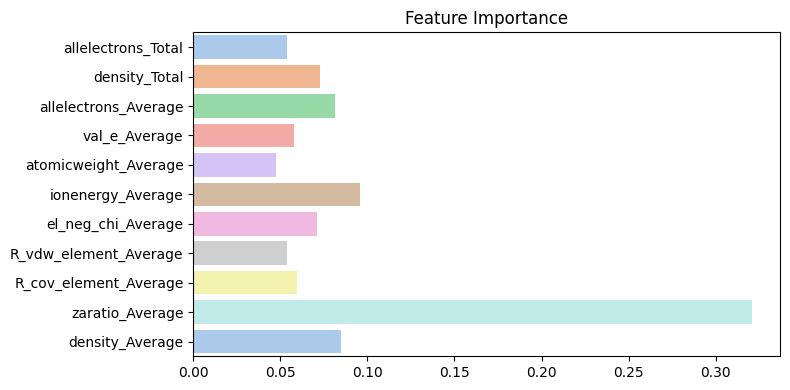

In [13]:
# Checkign coefficent method using Tree Method.

decisionTree = DecisionTreeRegressor()
decisionTree.fit(X_train, y_train)
decisionTreeImportance = decisionTree.feature_importances_
plt.figure(figsize=(8,4))
plt.title("Feature Importance")
sns.barplot(y=X_train.columns,x=decisionTreeImportance,palette=sns.color_palette('pastel'))#,color=color_pallet)
plt.tight_layout()

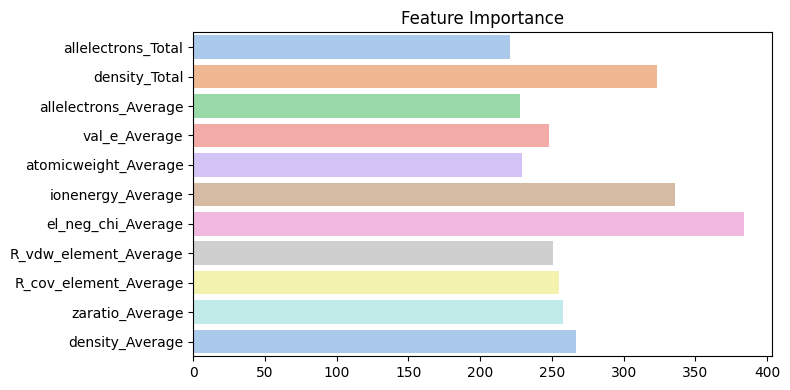

In [14]:
import lightgbm
lgb = lightgbm.LGBMRegressor(objective = 'mae')
lgb.fit(X_train, y_train)
lgbImportance = lgb.feature_importances_
plt.figure(figsize=(8,4))
plt.title("Feature Importance")
sns.barplot(y=X_train.columns,x=lgbImportance,palette=sns.color_palette('pastel'))
plt.tight_layout()

### Model Construction

#### Hyperparameter optimization with HyperOpt

In [15]:
params ={'max_depth': hp.quniform("max_depth", 3, 50, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'n_estimators': 180,
        'seed': 0,
         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         "eval_metric":'mae'
    }

In [16]:
def model(params):
    reg_model = XGBRegressor(
        n_estimators = params['n_estimators'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda'],
        colsample_bytree = params['colsample_bytree'],
        min_child_weight = params['min_child_weight'],
        eval_metric = params['eval_metric'],
        max_depth = int(params['max_depth']),
        gamma = params['gamma']
            )
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    reg_model.fit(X_train, y_train,verbose=False,eval_set=evaluation,early_stopping_rounds=10)
    pred = reg_model.predict(X_test)
    mae = mean_absolute_error(y_test,pred)
    return {'loss': mae, 'status': STATUS_OK }

In [17]:
trials = Trials()

best_hyperparams = fmin(fn = model,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [00:14<00:00,  6.83trial/s, best loss: 0.9316563785789946]


In [18]:
print("The best hyperparameters are : \n")
print(best_hyperparams)

The best hyperparameters are : 

{'colsample_bytree': 0.9331230486730526, 'gamma': 1.54034468553903, 'max_depth': 17.0, 'min_child_weight': 10.0, 'reg_alpha': 44.0, 'reg_lambda': 0.10257445129603637}


In [19]:
xgModel = XGBRegressor(max_depth=9,gamma= 3.906901890986637)
xgModel.fit(X_train,y_train)
y_pred = xgModel.predict(X_test)

In [20]:
print("Mean Absolute Error: ",mean_absolute_error(y_test,y_pred))
print("R2 value :", r2_score(y_test,y_pred))
print("Explained Variance Score",explained_variance_score(y_test,y_pred))

Mean Absolute Error:  0.9289825114049554
R2 value : 0.43279398618485576
Explained Variance Score 0.43283263404303807


In [21]:
np.int = np.int64

#### Hyperparameter optimization of XGBoost BayseSearch

In [22]:
bayseOptimizer = BayesSearchCV(
        XGBRegressor(),
    {
        'max_depth': (3,50),
        'gamma': (1,9,'log-uniform'),
         'reg_alpha' :(40,180,1),
        'n_estimators': (100, 140, 180, 220, 260),
        'reg_lambda' :(0,1),
        'colsample_bytree' : (0.5,1,"log-uniform"),
        'min_child_weight' : ( 0, 10,1),
    },
    n_iter=100,
    cv=5
)

bayseOptimizer.fit(X_train,y_train)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
              n_iter=100,
              search_spaces={'colsample_bytree': (0.5, 1, 'log-uniform'),
                             'gamma': (1, 9, 'log-uniform'),
                             'max_depth': (3, 50),
                             'min_child_weight': (0, 10, 1),
                             'n_estimators': (100, 140, 180, 220, 260),
                             'reg_alpha': (40, 180, 1), 'reg_lambda': (0, 1)})

In [23]:
print(f"Score of BayesSearchCV :",bayseOptimizer.best_score_)
print(f"Best Index BayesSearchCV :",bayseOptimizer.best_index_ )
print(f"Best Parameters BayesSearchCV :",bayseOptimizer.best_params_)

Score of BayesSearchCV : 0.46287631377423566
Best Index BayesSearchCV : 42
Best Parameters BayesSearchCV : OrderedDict([('colsample_bytree', 1), ('gamma', 1), ('max_depth', 3), ('min_child_weight', 0), ('n_estimators', 100), ('reg_alpha', 1), ('reg_lambda', 0)])


In [24]:
newXgModel = XGBRegressor(colsample_bytree = 1, gamma=1,max_depth= 3,min_child_weight=10, n_estimators =260, reg_alpha=1, reg_lambda=1)
newXgModel.fit(X_train, y_train)
new_y_pred = newXgModel.predict(X_test)

In [25]:
print("Mean Absolute Error: ",mean_absolute_error(y_test,new_y_pred))
print("R2 value :", r2_score(y_test,new_y_pred))
print("Explained Variance Score",explained_variance_score(y_test,new_y_pred))

Mean Absolute Error:  0.9106231419245402
R2 value : 0.4603328252833492
Explained Variance Score 0.4603632521256067


## Submission

In [26]:
test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [27]:
test_Y=newXgModel.predict(test.drop('id',axis=1))
submissions = pd.read_csv("/kaggle/input/playground-series-s3e25/sample_submission.csv")
submissions['Hardness'] = test_Y
submissions.to_csv("submissions.csv", index=False)

### Thank you